Test Notebook

In [1]:
import os

import torch
from pathlib import Path

import transforms
from model import UNET, Separator
from IPython.display import Audio
import numpy as np
import pandas as pd

In [32]:
import matplotlib.pyplot as plt
from pathlib import Path
import librosa

torch.random.manual_seed(0)


def plot_waveform(waveform, sr, title="Waveform", ylabel="amplitude", ax=None):
    waveform = waveform.cpu().numpy()
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(waveform, sr=sr, alpha=0.8)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", xlabel="time (ms)", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.imshow(librosa.power_to_db(specgram.cpu()), origin="lower", aspect="auto", interpolation="nearest")

In [39]:
model_dir = Path('../models')
model_name = '../model_4096_v1.pth'
model_file = model_dir / model_name
checkpoint = torch.load(model_name, weights_only=True)

In [40]:
model = UNET()
model.load_state_dict(checkpoint['state_dict'])
model.eval()

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): ResDoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): ResDoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2,

In [41]:
import musdb

musdb_testdata = musdb.DB('../musdb', download=False, subsets='test')

In [42]:
track = musdb_testdata[1]
mix_audio = torch.as_tensor(track.audio.T, dtype=torch.float32)
vocal_audio = torch.as_tensor(track.targets['vocals'].audio.T, dtype=torch.float32)

In [43]:
track.targets['vocals']

vocals

In [44]:
sep = Separator(n_fft=1024, hop_length=512, model=model, device='cuda', complex_data=False)

vocal_prediction = sep(mix_audio.unsqueeze(0))
vocal_prediction

tensor([[[ 0.0191, -0.0222,  0.0143,  ..., -0.0109, -0.0724, -0.0905],
         [ 0.1053,  0.0419,  0.0791,  ...,  0.0018, -0.0184, -0.0409]]],
       device='cuda:0')

In [45]:
import transforms

encoder, decoder = transforms.make_filterbanks(1024, 512, False, False)

In [46]:
vocal_pred_spec = encoder(vocal_prediction)
mix_spec = encoder(mix_audio)
vocal_spec = encoder(vocal_audio)

In [47]:
vocal_pred_spec

tensor([[[[1.8083e+00, 6.2690e-01, 6.5558e-01,  ..., 1.0074e-01,
           4.2770e-01, 5.0880e-01],
          [3.8590e-01, 1.1768e-01, 7.5794e-02,  ..., 2.0563e-02,
           7.9652e-02, 1.4119e+00],
          [2.4444e-01, 1.4915e-02, 3.2424e-02,  ..., 1.8277e-03,
           2.2030e-02, 3.1377e-01],
          ...,
          [1.6636e-01, 1.6039e-01, 1.5026e-01,  ..., 1.2329e-01,
           1.3873e-01, 2.2545e-01],
          [2.7870e-01, 1.8104e-01, 1.7937e-01,  ..., 1.5025e-01,
           1.9851e-01, 2.2666e-01],
          [8.3385e-01, 1.1830e+00, 1.0782e+00,  ..., 1.0976e+00,
           1.0092e+00, 1.1929e+00]],

         [[1.2428e+00, 3.6728e-01, 3.7921e-01,  ..., 3.4024e-02,
           1.3126e-01, 1.4405e+00],
          [2.7545e-01, 6.7720e-02, 4.1393e-02,  ..., 6.8418e-03,
           2.2790e-02, 2.8921e-01],
          [1.7126e-01, 9.7571e-03, 2.1266e-02,  ..., 7.9377e-04,
           4.6318e-03, 1.1846e-01],
          ...,
          [2.1337e-01, 1.8102e-01, 1.3120e-01,  ..., 1.5374

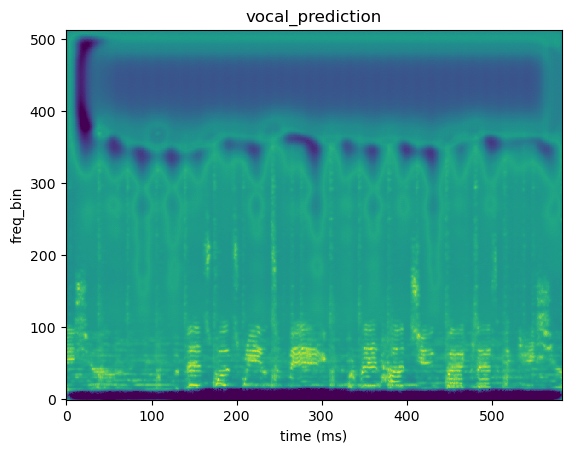

In [48]:
plot_spectrogram(vocal_pred_spec[0][0], title='vocal_prediction')

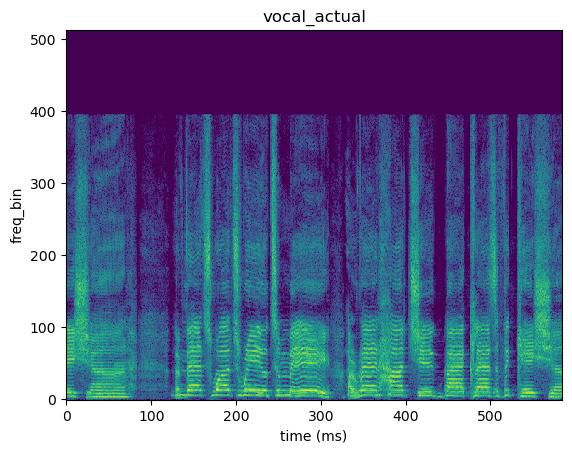

In [49]:
plot_spectrogram(vocal_spec[0], title='vocal_actual')

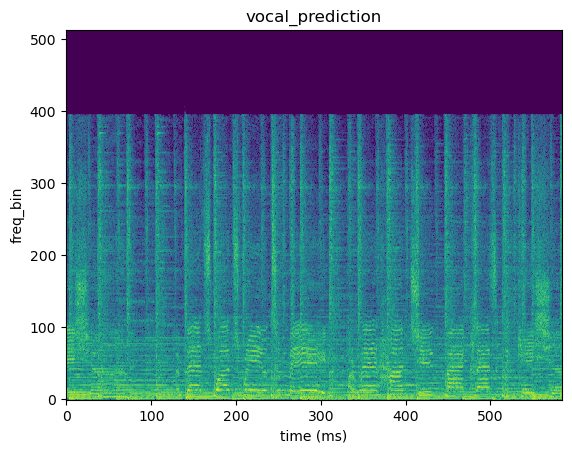

In [50]:
plot_spectrogram(mix_spec[0], title='vocal_prediction')

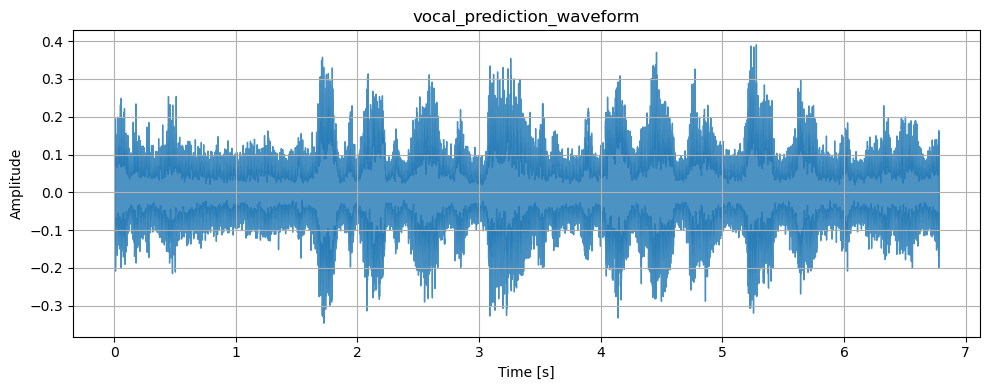

In [51]:
plot_waveform(vocal_prediction[0], sr=44100, title='vocal_prediction_waveform')

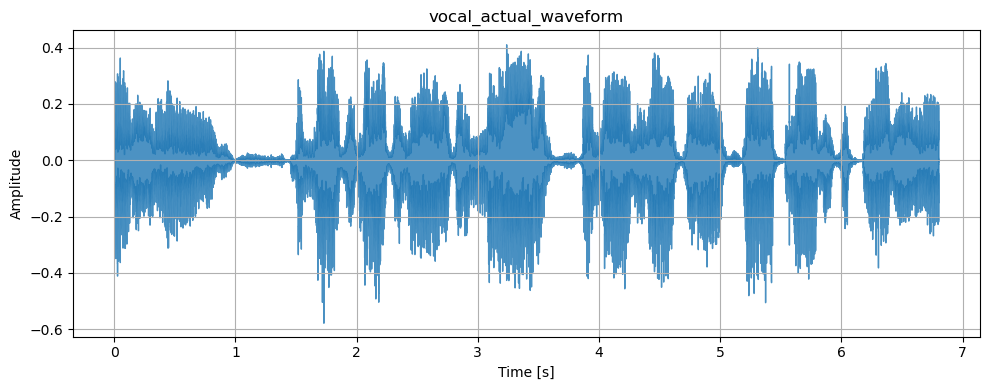

In [52]:
plot_waveform(vocal_audio, sr=44100, title='vocal_actual_waveform')

In [53]:
Audio(mix_audio, rate=44100)

In [54]:
Audio(vocal_prediction[0].cpu(), rate=44100)

In [31]:
import museval
from model import Separator

sep = Separator(n_fft=1024, hop_length=512, model=model, device='cuda', complex_data=False)

def estimate_and_evaluate(track, separator):
    mix_audio = torch.as_tensor(track.audio.T, dtype=torch.float32)
    vocal_prediction = sep(mix_audio.unsqueeze(0))[0].cpu().numpy().T

    # Calculate the padding length
    padding_length = track.targets['accompaniment'].audio.shape[0] - vocal_prediction.shape[0]

    # Pad with zeros
    vocal_pred_padded = np.pad(vocal_prediction, ((0,padding_length), (0, 0)), 'constant')

    # assume mix as estimates
    estimates = {
        'vocals': vocal_pred_padded,
        'accompaniment':track.audio
    }

    # Evaluate using museval
    scores = museval.eval_mus_track(
        track, estimates, output_dir="../eval"
    )

    return scores

In [179]:
from museval import EvalStore, MethodStore

results = EvalStore()
for track in musdb_testdata:
    scores = estimate_and_evaluate(track, sep)
    results.add_track(scores)

method = MethodStore()
method.add_evalstore(results, "UNET")
method.save("eval.pandas")

In [32]:
eval_score = pd.read_pickle("../eval/eval.pandas")

In [33]:
eval_score

time         target metric    score                         track method
0      0.0         vocals    SDR -5.87865  AM Contra - Heart Peripheral   UNET
1      1.0         vocals    SDR -5.00070  AM Contra - Heart Peripheral   UNET
2      2.0         vocals    SDR -5.85532  AM Contra - Heart Peripheral   UNET
3      3.0         vocals    SDR -7.68618  AM Contra - Heart Peripheral   UNET
4      4.0         vocals    SDR -7.55799  AM Contra - Heart Peripheral   UNET
...    ...            ...    ...      ...                           ...    ...
2395   1.0  accompaniment    SIR  1.56043                  Zeno - Signs   UNET
2396   2.0  accompaniment    SIR  1.66800                  Zeno - Signs   UNET
2397   3.0  accompaniment    SIR  2.00220                  Zeno - Signs   UNET
2398   4.0  accompaniment    SIR  9.64801                  Zeno - Signs   UNET
2399   5.0  accompaniment    SIR  1.54603                  Zeno - Signs   UNET

[2400 rows x 6 columns]

In [36]:
vocal_df = eval_score.loc[eval_score['target'] == 'vocals']

In [51]:
vocal_scores_df = vocal_df.loc[:, ['metric', 'score']]

In [53]:
vocal_scores_df.groupby('metric')['score'].mean().reset_index()

metric      score
0    ISR  -1.741754
1    SAR -10.584725
2    SDR  -8.669975
3    SIR   2.534616

Load From Numpy File

In [18]:
import numpy as np

pred_batch = np.load('../saved_spectrograms/9/predbatch_50.npy')
pred_batch.shape

(4, 2, 513, 585)

In [19]:
pred = torch.from_numpy(pred_batch[0]).to('cuda')
pred

tensor([[[ 14.7338,  29.2177,  35.6677,  ...,  24.3456,  21.6779,  11.2504],
         [ 21.8633,  99.1884,  48.8659,  ...,  13.6795,  18.4752,  14.4105],
         [ 44.1165, 114.3330,  41.4519,  ...,   8.5746,  15.1726,   9.3708],
         ...,
         [ 10.8124,  16.8460,   3.9047,  ...,   5.6080,  11.7985,  15.0673],
         [ 13.6480,  12.8197,   5.9257,  ...,   5.4478,  10.7333,  18.3148],
         [ 47.1708,  33.7250,  12.0922,  ...,  27.8579,  48.7999,  78.4530]],

        [[ 19.2083,  33.2332,  29.2780,  ...,  19.9170,  27.6634,   8.4732],
         [ 20.4255,  90.1030,  35.4981,  ...,   9.6559,  16.6567,   9.0220],
         [ 30.6450,  79.9417,  38.0503,  ...,   7.8981,  11.0415,   7.4333],
         ...,
         [  7.9184,  10.6870,   3.2105,  ...,   4.5145,   8.0386,   9.9369],
         [ 14.1335,  11.1933,   4.4373,  ...,   4.1827,   9.1163,  13.4977],
         [ 37.6363,  23.9491,  10.8809,  ...,  24.8503,  34.8660,  61.5477]]],
       device='cuda:0')

In [20]:
from transforms import make_filterbanks

stft, istft = make_filterbanks(
            n_fft=1024,
            hop_length=512,
            center=False,
            sample_rate=44100.0,
            device='cuda'
        )

In [21]:
pred_audio = istft(pred)
pred_audio.shape

torch.Size([2, 299008])

In [22]:
from IPython.display import Audio

Audio(pred_audio.cpu(), rate=44100)

Testing Train Dataset

In [9]:
from dataset import MUSDBDataset

train_dataset = MUSDBDataset('./musdb')

train_dataset.shape

(tensor([[ 0.0292,  0.0267,  0.0082,  ..., -0.0131, -0.0286, -0.0517],
         [ 0.0468,  0.0305,  0.0042,  ..., -0.1584, -0.1554, -0.1486]]),
 tensor([[-0.0260, -0.0229, -0.0198,  ..., -0.0267, -0.0140, -0.0039],
         [ 0.0040,  0.0041,  0.0042,  ..., -0.0243, -0.0056,  0.0082]]))

In [19]:
audio, vocal = train_dataset[71]

In [20]:
Audio(audio, rate=44100)

In [21]:
Audio(vocal, rate=44100)